### Importing Necessary Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import os

### Mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/GoogleDrive/')

Mounted at /content/GoogleDrive/


### Checking GPU Access

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading the Dataset

In [4]:
train_ds, val_ds, test_ds = tfds.load(
                                      'cifar10',
                                       split = ['train[:40000]', 'train[40000:]', 'test'],
                                       as_supervised = True
)

# Source: https://www.tensorflow.org/datasets/api_docs/python/tfds/load, https://www.tensorflow.org/datasets/splits

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteUI3JE1/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteUI3JE1/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
tf.data.experimental.cardinality(train_ds).numpy(), tf.data.experimental.cardinality(val_ds).numpy(), tf.data.experimental.cardinality(test_ds).numpy()

(40000, 10000, 10000)

### Checking Class Distribution

In [ ]:
def get_class_distribution(ds, num_classes):
  count = [0]*num_classes
  for item in ds:
    count[item[1].numpy()] += 1
  return count

In [ ]:
get_class_distribution(train_ds, 10) # relatively balanced

[4075, 3995, 4006, 3991, 4021, 4011, 4013, 4003, 3976, 3909]

In [ ]:
get_class_distribution(val_ds, 10) # relatively balanced as well

[925, 1005, 994, 1009, 979, 989, 987, 997, 1024, 1091]

### Data Preprocessing

In [5]:
def normalize(image, label):
  return tf.cast(image, tf.float32) / 255., label

def preprocess(ds, training = True):
  ds = ds.map(normalize, num_parallel_calls = tf.data.AUTOTUNE)
  if training:
    ds = ds.cache()
    ds = ds.shuffle(40000)
    ds = ds.batch(64)
    ds = ds.prefetch(tf.data.AUTOTUNE)
  else:
    ds = ds.batch(64)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

# Source: https://www.tensorflow.org/datasets/keras_example

In [6]:
train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds, training = False)
test_ds = preprocess(test_ds, training = False)

### Creating the Model

In [ ]:
! pip install git+https://github.com/fversaci/WaveTF.git 

  Cloning https://github.com/fversaci/WaveTF.git to /tmp/pip-req-build-5bsgc28h
  Running command git clone -q https://github.com/fversaci/WaveTF.git /tmp/pip-req-build-5bsgc28h
  Created wheel for WaveTF: filename=WaveTF-0.1-py3-none-any.whl size=25282 sha256=ef8c18f9c2347f737415eaca72dca8c92075126d3eb0b0d72f7dd15e3ca7e1d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0liz6c0/wheels/8e/ec/3d/1b322bbe7f99f023e33f5ae0fa6716e29abadde70a3ac6d299
Successfully built WaveTF


In [ ]:
from wavetf import WaveTFFactory

In [ ]:
class WaveletBlock(layers.Layer):
  def __init__(self, input_channels, wavelet, interpolation, **kwargs):
    super().__init__(**kwargs)
    self.input_channels = input_channels
    self.wavelet = wavelet
    self.interpolation = interpolation
    self.wavelet_transform = WaveTFFactory.build(wavelet)
    self.cA = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cH = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cV = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.cD = [layers.UpSampling2D(size = (2,2), interpolation = interpolation),
               layers.DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same'),
               layers.BatchNormalization(),
               layers.Activation('relu')
              ]
    self.concat = layers.Concatenate(axis = -1)
    self.linear = [layers.Conv2D(filters = input_channels, kernel_size = (1,1), strides = (1,1), padding = 'same'),
                   layers.BatchNormalization()
                  ]

  def call(self, inputs):
    z = self.wavelet_transform(inputs)

    cA = z[:,:,:,:self.input_channels]
    cV = z[:,:,:,self.input_channels:2*self.input_channels]
    cH = z[:,:,:,2*self.input_channels:3*self.input_channels]
    cD = z[:,:,:,3*self.input_channels:]

    for layer in self.cA:
      cA = layer(cA)
    for layer in self.cV:
      cV = layer(cV) 
    for layer in self.cH:
      cH = layer(cH) 
    for layer in self.cD:
      cD = layer(cD) 
    
    out = self.concat([cA,cV,cH,cD])

    for layer in self.linear:
      out = layer(out)
      
    return out + inputs

In [ ]:
def build_cifar10_model(wavelet, interpolation):
  model = Sequential([layers.Input(shape = (32, 32, 3), name = 'input'),
                      layers.RandomFlip(mode = 'horizontal', name = 'random_flip'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      WaveletBlock(input_channels = 32, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_1'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      WaveletBlock(input_channels = 64, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_2'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      WaveletBlock(input_channels = 64, wavelet = wavelet, interpolation = interpolation, name = 'wavelet_block_3'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_4'),
                      layers.BatchNormalization(name = 'conv2d_4_bn'),
                      layers.Activation('relu', name = 'conv2d_4_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.4, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'{wavelet}_{interpolation}_model')
  return model

In [ ]:
def train_model(model, wavelet, interpolation, initial_epoch = 0, epochs = 100):
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
  dir_model = f'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/{wavelet}_{interpolation}_cifar10.h5'
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True, save_weights_only = True)
  with tf.device('/device:GPU:0'):
    history = model.fit(
                        x = train_ds,
                        initial_epoch = initial_epoch,
                        epochs = epochs, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )
  return history

### Haar-Nearest

In [ ]:
haar_nearest = build_cifar10_model('haar', 'nearest')

In [ ]:
haar_nearest.summary()

Model: "haar_nearest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 32, 32, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 32, 32, 32)        0         
                                                                 
 wavelet_block_1 (WaveletBlo  (None, 32, 32, 32)

In [ ]:
haar_nearest_history = train_model(haar_nearest, 'haar', 'nearest')

Epoch 1/100
625/625 [==============================] - 115s 146ms/step - loss: 1.4053 - accuracy: 0.4887 - val_loss: 1.4878 - val_accuracy: 0.4440
Epoch 2/100
625/625 [==============================] - 86s 138ms/step - loss: 1.1114 - accuracy: 0.6027 - val_loss: 1.4949 - val_accuracy: 0.5048
Epoch 3/100
625/625 [==============================] - 86s 137ms/step - loss: 1.0022 - accuracy: 0.6459 - val_loss: 0.9987 - val_accuracy: 0.6417
Epoch 4/100
625/625 [==============================] - 86s 138ms/step - loss: 0.9419 - accuracy: 0.6659 - val_loss: 1.5747 - val_accuracy: 0.5360
Epoch 5/100
625/625 [==============================] - 86s 138ms/step - loss: 0.8910 - accuracy: 0.6852 - val_loss: 0.8589 - val_accuracy: 0.6962
Epoch 6/100
625/625 [==============================] - 86s 138ms/step - loss: 0.8542 - accuracy: 0.6998 - val_loss: 0.8125 - val_accuracy: 0.7156
Epoch 7/100
625/625 [==============================] - 86s 137ms/step - loss: 0.8149 - accuracy: 0.7119 - val_loss: 0.9560 

In [ ]:
haar_nearest.evaluate(test_ds)

157/157 [==============================] - 8s 47ms/step - loss: 0.6120 - accuracy: 0.8132


[0.611996054649353, 0.8131999969482422]

In [ ]:
haar_nearest_saved = build_cifar10_model('haar', 'nearest')
haar_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/haar_nearest_cifar10.h5')
haar_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 9s 46ms/step - loss: 0.5145 - accuracy: 0.8355


[0.5145137906074524, 0.8355000019073486]

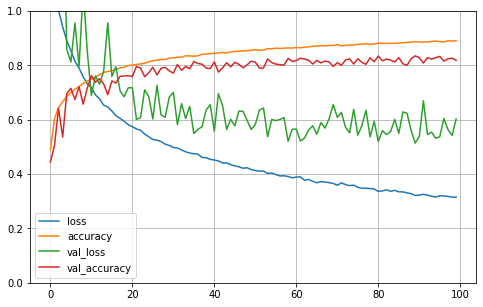

In [ ]:
pd.DataFrame(haar_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Haar-Bilinear

In [ ]:
haar_bilinear = build_cifar10_model('haar', 'bilinear')

In [ ]:
haar_bilinear.summary()

Model: "haar_bilinear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 32, 32, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 32, 32, 32)        0         
                                                                 
 wavelet_block_1 (WaveletBlo  (None, 32, 32, 32

In [ ]:
haar_bilinear_history = train_model(haar_bilinear, 'haar', 'bilinear')

Epoch 1/100
625/625 [==============================] - 106s 141ms/step - loss: 1.3988 - accuracy: 0.4893 - val_loss: 1.3627 - val_accuracy: 0.5008
Epoch 2/100
625/625 [==============================] - 87s 138ms/step - loss: 1.1089 - accuracy: 0.6018 - val_loss: 1.3285 - val_accuracy: 0.5312
Epoch 3/100
625/625 [==============================] - 86s 138ms/step - loss: 1.0010 - accuracy: 0.6438 - val_loss: 1.1353 - val_accuracy: 0.5930
Epoch 4/100
625/625 [==============================] - 86s 138ms/step - loss: 0.9352 - accuracy: 0.6712 - val_loss: 0.9927 - val_accuracy: 0.6423
Epoch 5/100
625/625 [==============================] - 86s 137ms/step - loss: 0.8880 - accuracy: 0.6855 - val_loss: 1.0945 - val_accuracy: 0.6174
Epoch 6/100
625/625 [==============================] - 86s 137ms/step - loss: 0.8465 - accuracy: 0.7023 - val_loss: 1.4248 - val_accuracy: 0.5667
Epoch 7/100
625/625 [==============================] - 86s 137ms/step - loss: 0.8130 - accuracy: 0.7134 - val_loss: 1.1288 

In [ ]:
haar_bilinear.evaluate(test_ds)

157/157 [==============================] - 7s 45ms/step - loss: 0.6211 - accuracy: 0.8073


[0.6210705041885376, 0.8072999715805054]

In [ ]:
haar_bilinear_saved = build_cifar10_model('haar', 'bilinear')
haar_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/haar_bilinear_cifar10.h5')
haar_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
haar_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 8s 44ms/step - loss: 0.5064 - accuracy: 0.8330


[0.5064242482185364, 0.8330000042915344]

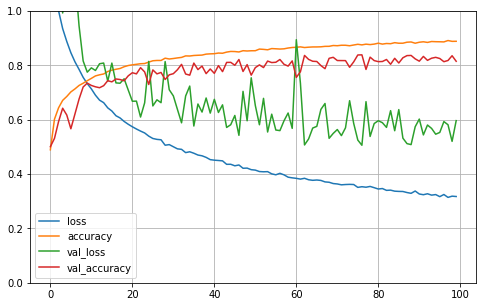

In [ ]:
pd.DataFrame(haar_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### DB2-Nearest

In [ ]:
db2_nearest = build_cifar10_model('db2', 'nearest')

In [ ]:
db2_nearest_history = train_model(db2_nearest, 'db2', 'nearest')

Epoch 1/100
625/625 [==============================] - 126s 161ms/step - loss: 1.4247 - accuracy: 0.4802 - val_loss: 1.4379 - val_accuracy: 0.4789
Epoch 2/100
625/625 [==============================] - 98s 157ms/step - loss: 1.1043 - accuracy: 0.6026 - val_loss: 1.1832 - val_accuracy: 0.5817
Epoch 3/100
625/625 [==============================] - 98s 157ms/step - loss: 0.9964 - accuracy: 0.6427 - val_loss: 0.9574 - val_accuracy: 0.6578
Epoch 4/100
625/625 [==============================] - 98s 157ms/step - loss: 0.9312 - accuracy: 0.6707 - val_loss: 0.8776 - val_accuracy: 0.6914
Epoch 5/100
625/625 [==============================] - 98s 157ms/step - loss: 0.8827 - accuracy: 0.6896 - val_loss: 0.9444 - val_accuracy: 0.6633
Epoch 6/100
625/625 [==============================] - 98s 156ms/step - loss: 0.8449 - accuracy: 0.7014 - val_loss: 0.8854 - val_accuracy: 0.6916
Epoch 7/100
625/625 [==============================] - 99s 158ms/step - loss: 0.8050 - accuracy: 0.7164 - val_loss: 0.8742 

In [ ]:
db2_nearest.evaluate(test_ds)

157/157 [==============================] - 9s 54ms/step - loss: 0.5347 - accuracy: 0.8270


[0.5346798896789551, 0.8270000219345093]

In [ ]:
db2_nearest_saved = build_cifar10_model('db2', 'nearest')
db2_nearest_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/db2_nearest_cifar10.h5')
db2_nearest_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_nearest_saved.evaluate(test_ds)

157/157 [==============================] - 10s 53ms/step - loss: 0.5075 - accuracy: 0.8344


[0.5074734091758728, 0.8343999981880188]

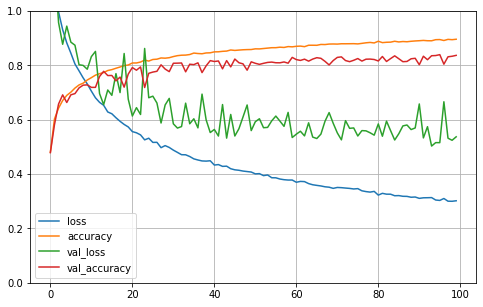

In [ ]:
pd.DataFrame(db2_nearest_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### DB2-Bilinear

In [ ]:
db2_bilinear = build_cifar10_model('db2', 'bilinear')

In [ ]:
db2_bilinear_history = train_model(db2_bilinear, 'db2', 'bilinear')

Epoch 1/100
625/625 [==============================] - 126s 162ms/step - loss: 1.4449 - accuracy: 0.4697 - val_loss: 1.6287 - val_accuracy: 0.4398
Epoch 2/100
625/625 [==============================] - 99s 158ms/step - loss: 1.1351 - accuracy: 0.5931 - val_loss: 1.2981 - val_accuracy: 0.5226
Epoch 3/100
625/625 [==============================] - 99s 159ms/step - loss: 1.0329 - accuracy: 0.6328 - val_loss: 1.0774 - val_accuracy: 0.6226
Epoch 4/100
625/625 [==============================] - 98s 157ms/step - loss: 0.9680 - accuracy: 0.6548 - val_loss: 1.1446 - val_accuracy: 0.5866
Epoch 5/100
625/625 [==============================] - 99s 158ms/step - loss: 0.9146 - accuracy: 0.6759 - val_loss: 1.4680 - val_accuracy: 0.5124
Epoch 6/100
625/625 [==============================] - 99s 159ms/step - loss: 0.8819 - accuracy: 0.6865 - val_loss: 0.9545 - val_accuracy: 0.6613
Epoch 7/100
625/625 [==============================] - 98s 157ms/step - loss: 0.8485 - accuracy: 0.6991 - val_loss: 1.1976 

In [ ]:
db2_bilinear.evaluate(test_ds)

157/157 [==============================] - 8s 53ms/step - loss: 0.6656 - accuracy: 0.7932


[0.6656020879745483, 0.7932000160217285]

In [ ]:
db2_bilinear_saved = build_cifar10_model('db2', 'bilinear')
db2_bilinear_saved.load_weights('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/db2_bilinear_cifar10.h5')
db2_bilinear_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
db2_bilinear_saved.evaluate(test_ds)

157/157 [==============================] - 10s 52ms/step - loss: 0.5384 - accuracy: 0.8277


[0.5384404063224792, 0.8277000188827515]

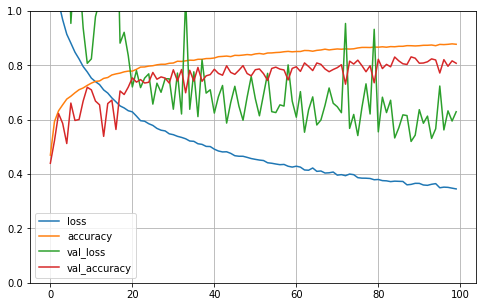

In [ ]:
pd.DataFrame(db2_bilinear_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Fully Conv

In [7]:
fully_conv = Sequential([layers.Input(shape = (32, 32, 3), name = 'input'),
                      layers.RandomFlip(mode = 'horizontal', name = 'random_flip'),
                      layers.RandomRotation(factor = 10/360, name = 'random_rotation'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_1'),
                      layers.BatchNormalization(name = 'conv2d_1_bn'),
                      layers.Activation('relu', name = 'conv2d_1_relu'),
                      layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_2'),
                      layers.BatchNormalization(name = 'conv2d_2_bn'),
                      layers.Activation('relu', name = 'conv2d_2_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_3'),
                      layers.BatchNormalization(name = 'conv2d_3_bn'),
                      layers.Activation('relu', name = 'conv2d_3_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_4'),
                      layers.BatchNormalization(name = 'conv2d_4_bn'),
                      layers.Activation('relu', name = 'conv2d_4_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_5'),
                      layers.BatchNormalization(name = 'conv2d_5_bn'),
                      layers.Activation('relu', name = 'conv2d_5_relu'),
                      layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', name = 'conv2d_6'),
                      layers.BatchNormalization(name = 'conv2d_6_bn'),
                      layers.Activation('relu', name = 'conv2d_6_relu'),
                      layers.Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same', name = 'conv2d_7'),
                      layers.BatchNormalization(name = 'conv2d_7_bn'),
                      layers.Activation('relu', name = 'conv2d_7_relu'),
                      layers.GlobalAveragePooling2D(name = 'avgpooling'),
                      layers.Dropout(0.4, name = 'dropout'),
                      layers.Dense(units = 10, activation = 'softmax', name = 'predictions')],
                     name = f'fully_conv_model')

In [8]:
fully_conv.summary()

Model: "fully_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_1_bn (BatchNormaliza  (None, 32, 32, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1_relu (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)   

In [9]:
optimizer = tf.keras.optimizers.Adam(0.001)
fully_conv.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
dir_model = 'GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/fully_conv_cifar10.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(dir_model, save_best_only = True)
with tf.device('/device:GPU:0'):
  fully_conv_history = fully_conv.fit(
                        x = train_ds,
                        epochs = 100, 
                        callbacks = [checkpoint_cb],
                        validation_data = val_ds
                        )

Epoch 1/100
625/625 [==============================] - 63s 63ms/step - loss: 1.5526 - accuracy: 0.4270 - val_loss: 1.4241 - val_accuracy: 0.4767
Epoch 2/100
625/625 [==============================] - 38s 60ms/step - loss: 1.1725 - accuracy: 0.5757 - val_loss: 1.4294 - val_accuracy: 0.5042
Epoch 3/100
625/625 [==============================] - 38s 61ms/step - loss: 1.0196 - accuracy: 0.6380 - val_loss: 1.2527 - val_accuracy: 0.5681
Epoch 4/100
625/625 [==============================] - 38s 61ms/step - loss: 0.9321 - accuracy: 0.6678 - val_loss: 1.1700 - val_accuracy: 0.6129
Epoch 5/100
625/625 [==============================] - 37s 60ms/step - loss: 0.8604 - accuracy: 0.6955 - val_loss: 1.6824 - val_accuracy: 0.4500
Epoch 6/100
625/625 [==============================] - 38s 61ms/step - loss: 0.8046 - accuracy: 0.7186 - val_loss: 0.8418 - val_accuracy: 0.7013
Epoch 7/100
625/625 [==============================] - 38s 61ms/step - loss: 0.7620 - accuracy: 0.7343 - val_loss: 0.8138 - val_ac

In [10]:
fully_conv.evaluate(test_ds)    

157/157 [==============================] - 3s 19ms/step - loss: 0.7276 - accuracy: 0.8113


[0.7276346683502197, 0.8112999796867371]

In [11]:
fully_conv_saved = keras.models.load_model('GoogleDrive/MyDrive/MATH 199.1 - ThesisIt/03 Programs/9 - WaveletBlock/cifar10/fully_conv_cifar10.h5')
fully_conv_saved.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
fully_conv_saved.evaluate(test_ds)

157/157 [==============================] - 3s 17ms/step - loss: 0.4985 - accuracy: 0.8500


[0.49853095412254333, 0.8500000238418579]

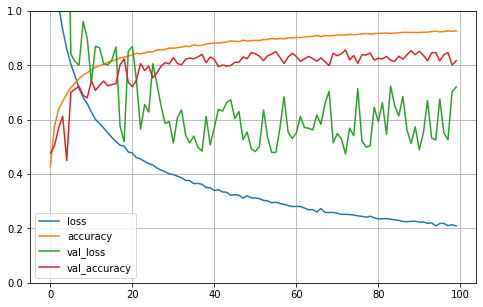

In [12]:
pd.DataFrame(fully_conv_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()